### *Disclaimer: the Keras implementation of SSD that was used for the vehicle detection in this project, is from https://github.com/rykov8/ssd_keras*

In [1]:
!pip install -r requirements.txt

In [2]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf

from ssd import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline

Using TensorFlow backend.


# Import model and define classes

In [3]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

premodel weights url: https://pan.baidu.com/s/1pLK5brd

In [6]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)
model.summary()
print("ssd layers number is %d"%len(model.layers))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 300, 300, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 300, 300, 64)  1792        input_3[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 300, 300, 64)  36928       conv1_1[0][0]                    
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 150, 150, 64)  0           conv1_2[0][0]                    
___________________________________________________________________________________________

# Apply vehicle detection on image

In [7]:
# Read image
inputs = []
img_path = './test_images/test1.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)

In [8]:
inputs = preprocess_input(np.array([img.copy()]))

In [9]:
# Run predictions
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/1 [==============================] - 0s


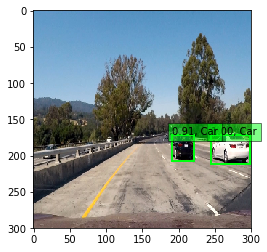

In [13]:
# Parse the outputs.
det_label = results[0][:, 0]
det_conf = results[0][:, 1]
det_xmin = results[0][:, 2]
det_ymin = results[0][:, 3]
det_xmax = results[0][:, 4]
det_ymax = results[0][:, 5]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.imshow(img / 255.)
currentAxis = plt.gca()

for i in range(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * img.shape[1]))
    ymin = int(round(top_ymin[i] * img.shape[0]))
    xmax = int(round(top_xmax[i] * img.shape[1]))
    ymax = int(round(top_ymax[i] * img.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = voc_classes[label - 1]
    display_txt = '{:0.2f}, {}'.format(score, label_name)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

plt.show()

In [42]:
# Function definition to apply vehicle detection on image
def img_detect_vehicle(img):
    dst = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
    inputs = preprocess_input(np.array([image.img_to_array(dst).copy()]))
    preds = model.predict(inputs, batch_size=1, verbose=1)
    results = bbox_util.detection_out(preds)

    # Parse the outputs.
    det_label = results[0][:, 0]
    det_conf = results[0][:, 1]
    det_xmin = results[0][:, 2]
    det_ymin = results[0][:, 3]
    det_xmax = results[0][:, 4]
    det_ymax = results[0][:, 5]
    
    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6 and det_label[i]==7]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(0, 0, 255), 4)
        cv2.putText(img, display_txt, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0), 4)
    return img

1/1 [==============================] - 0s


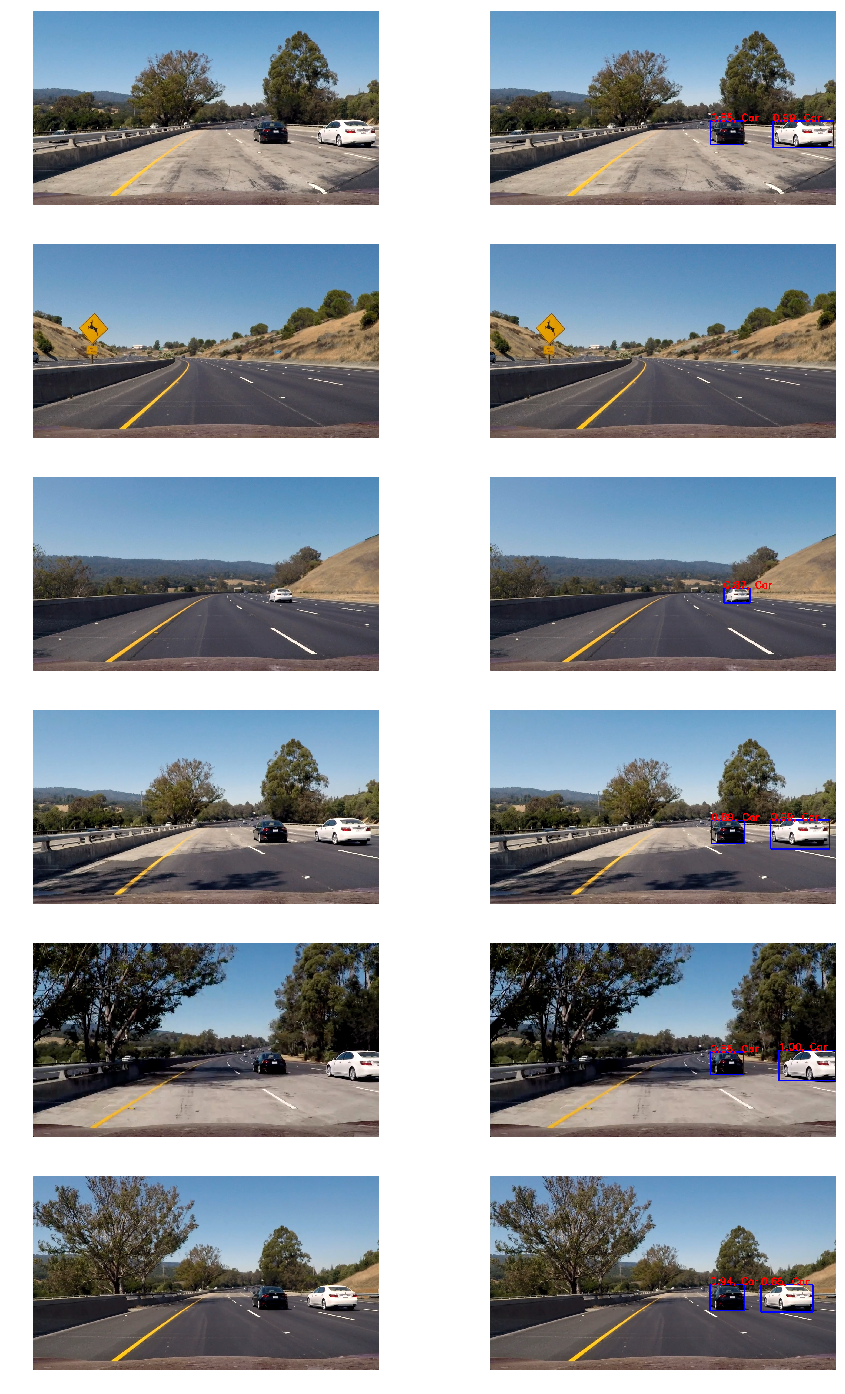

In [43]:
plt.figure(figsize=(15,25))

for i in range(1,7):
    img = cv2.imread('test_images/test%d.jpg'%i)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(6,2,(2*i-1))
    plt.imshow(img)
    plt.axis('off')
    res = img_detect_vehicle(img)
    plt.subplot(6,2,(2*i))
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Apply vehicle detection on video

In [44]:
!pip install moviepy

In [49]:
import imageio
imageio.plugins.ffmpeg.download()
print("done")

done


In [47]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
pv_output = 'output_videos/project_video_ssd_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(img_detect_vehicle)
%time white_clip.write_videofile(pv_output, audio=False)

1/1 [==============================] - 0s
[MoviePy] >>>> Building video output_videos/project_video_ssd_output.mp4
[MoviePy] Writing video output_videos/project_video_ssd_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

1/1 [==============================] - 0s

  0%|          | 5/1261 [00:00<00:31, 39.37it/s]


1/1 [==============================] - 0s

  1%|          | 9/1261 [00:00<00:32, 39.06it/s]


1/1 [==============================] - 0s

  1%|          | 14/1261 [00:00<00:31, 39.81it/s]


1/1 [==============================] - 0s

  2%|▏         | 19/1261 [00:00<00:30, 40.73it/s]


1/1 [==============================] - 0s

  2%|▏         | 24/1261 [00:00<00:29, 41.46it/s]


1/1 [==============================] - 0s

  2%|▏         | 29/1261 [00:00<00:29, 42.06it/s]


1/1 [==============================] - 0s

  3%|▎         | 34/1261 [00:00<00:28, 42.40it/s]


1/1 [==============================] - 0s

  3%|▎         | 39/1261 [00:00<00:28, 42.50it/s]


1/1 [==============================] - 0s

  3%|▎         | 44/1261 [00:01<00:28, 42.05it/s]


1/1 [==============================] - 0s


  4%|▍         | 49/1261 [00:01<00:30, 39.18it/s]

1/1 [==============================] - 0s


  4%|▍         | 53/1261 [00:01<00:30, 39.22it/s]

1/1 [==============================] - 0s

  5%|▍         | 57/1261 [00:01<00:30, 39.02it/s]


1/1 [==============================] - 0s

  5%|▍         | 61/1261 [00:01<00:30, 38.87it/s]


1/1 [==============================] - 0s


  5%|▌         | 65/1261 [00:01<00:32, 36.77it/s]

1/1 [==============================] - 0s

  5%|▌         | 69/1261 [00:01<00:32, 36.44it/s]


1/1 [==============================] - 0s

  6%|▌         | 74/1261 [00:01<00:31, 37.33it/s]


1/1 [==============================] - 0s

  6%|▌         | 78/1261 [00:01<00:32, 36.92it/s]


1/1 [==============================] - 0s

  7%|▋         | 82/1261 [00:02<00:32, 35.75it/s]


1/1 [==============================] - 0s

  7%|▋         | 86/1261 [00:02<00:32, 35.68it/s]


1/1 [==============================] - 0s

  7%|▋         | 90/1261 [00:02<00:32, 36.13it/s]


1/1 [==============================] - 0s

  7%|▋         | 94/1261 [00:02<00:31, 36.47it/s]


1/1 [==============================] - 0s

  8%|▊         | 98/1261 [00:02<00:31, 37.00it/s]


1/1 [==============================] - 0s

  8%|▊         | 102/1261 [00:02<00:30, 37.63it/s]


1/1 [==============================] - 0s

  8%|▊         | 106/1261 [00:02<00:30, 38.04it/s]


1/1 [==============================] - 0s

  9%|▊         | 110/1261 [00:02<00:30, 38.20it/s]


1/1 [==============================] - 0s

  9%|▉         | 114/1261 [00:02<00:29, 38.42it/s]


1/1 [==============================] - 0s

  9%|▉         | 119/1261 [00:03<00:29, 38.44it/s]


1/1 [==============================] - 0s

 10%|▉         | 124/1261 [00:03<00:29, 38.96it/s]


1/1 [==============================] - 0s


 10%|█         | 128/1261 [00:03<00:28, 39.16it/s]

1/1 [==============================] - 0s

 10%|█         | 132/1261 [00:03<00:28, 39.32it/s]


1/1 [==============================] - 0s

 11%|█         | 136/1261 [00:03<00:28, 39.14it/s]


1/1 [==============================] - 0s

 11%|█         | 140/1261 [00:03<00:29, 37.97it/s]


1/1 [==============================] - 0s

 11%|█▏        | 144/1261 [00:03<00:29, 38.00it/s]


1/1 [==============================] - 0s

 12%|█▏        | 148/1261 [00:03<00:29, 38.18it/s]


1/1 [==============================] - 0s

 12%|█▏        | 153/1261 [00:03<00:28, 38.84it/s]


1/1 [==============================] - 0s


 12%|█▏        | 157/1261 [00:04<00:28, 39.16it/s]

1/1 [==============================] - 0s

 13%|█▎        | 161/1261 [00:04<00:28, 38.64it/s]


1/1 [==============================] - 0s

 13%|█▎        | 165/1261 [00:04<00:28, 37.93it/s]


1/1 [==============================] - 0s

 13%|█▎        | 169/1261 [00:04<00:28, 38.20it/s]


1/1 [==============================] - 0s


 14%|█▍        | 174/1261 [00:04<00:27, 39.09it/s]

1/1 [==============================] - 0s


 14%|█▍        | 178/1261 [00:04<00:27, 38.92it/s]

1/1 [==============================] - 0s

 15%|█▍        | 183/1261 [00:04<00:27, 39.38it/s]


1/1 [==============================] - 0s

 15%|█▍        | 187/1261 [00:04<00:27, 39.17it/s]


1/1 [==============================] - 0s

 15%|█▌        | 191/1261 [00:04<00:27, 39.03it/s]


1/1 [==============================] - 0s

 15%|█▌        | 195/1261 [00:05<00:27, 38.59it/s]


1/1 [==============================] - 0s

 16%|█▌        | 200/1261 [00:05<00:27, 39.12it/s]


1/1 [==============================] - 0s

 16%|█▌        | 204/1261 [00:05<00:26, 39.16it/s]


1/1 [==============================] - 0s

 16%|█▋        | 208/1261 [00:05<00:26, 39.18it/s]


1/1 [==============================] - 0s

 17%|█▋        | 213/1261 [00:05<00:26, 39.56it/s]


1/1 [==============================] - 0s

 17%|█▋        | 217/1261 [00:05<00:26, 38.75it/s]


1/1 [==============================] - 0s

 18%|█▊        | 222/1261 [00:05<00:26, 39.38it/s]


1/1 [==============================] - 0s

 18%|█▊        | 226/1261 [00:05<00:26, 38.85it/s]


1/1 [==============================] - 0s

 18%|█▊        | 230/1261 [00:05<00:27, 38.16it/s]


1/1 [==============================] - 0s

 19%|█▊        | 234/1261 [00:06<00:27, 37.07it/s]


1/1 [==============================] - 0s

 19%|█▉        | 238/1261 [00:06<00:27, 37.44it/s]


1/1 [==============================] - 0s

 19%|█▉        | 242/1261 [00:06<00:27, 37.63it/s]


1/1 [==============================] - 0s

 20%|█▉        | 246/1261 [00:06<00:27, 37.52it/s]


1/1 [==============================] - 0s

 20%|█▉        | 251/1261 [00:06<00:26, 38.64it/s]


1/1 [==============================] - 0s

 20%|██        | 255/1261 [00:06<00:26, 38.36it/s]


1/1 [==============================] - 0s

 21%|██        | 259/1261 [00:06<00:25, 38.72it/s]


1/1 [==============================] - 0s

 21%|██        | 263/1261 [00:06<00:25, 38.49it/s]


1/1 [==============================] - 0s

 21%|██        | 267/1261 [00:06<00:25, 38.46it/s]


1/1 [==============================] - 0s

 21%|██▏       | 271/1261 [00:07<00:25, 38.21it/s]


1/1 [==============================] - 0s

 22%|██▏       | 276/1261 [00:07<00:25, 38.99it/s]


1/1 [==============================] - 0s

 22%|██▏       | 280/1261 [00:07<00:25, 38.64it/s]


1/1 [==============================] - 0s

 23%|██▎       | 284/1261 [00:07<00:25, 38.35it/s]


1/1 [==============================] - 0s

 23%|██▎       | 288/1261 [00:07<00:25, 38.38it/s]


1/1 [==============================] - 0s

 23%|██▎       | 292/1261 [00:07<00:25, 38.40it/s]


1/1 [==============================] - 0s

 23%|██▎       | 296/1261 [00:07<00:25, 37.29it/s]


1/1 [==============================] - 0s

 24%|██▍       | 300/1261 [00:07<00:25, 37.69it/s]


1/1 [==============================] - 0s

 24%|██▍       | 304/1261 [00:07<00:24, 38.31it/s]


1/1 [==============================] - 0s


 24%|██▍       | 308/1261 [00:07<00:24, 38.72it/s]

1/1 [==============================] - 0s

 25%|██▍       | 312/1261 [00:08<00:24, 38.86it/s]


1/1 [==============================] - 0s

 25%|██▌       | 316/1261 [00:08<00:24, 38.31it/s]


1/1 [==============================] - 0s

 25%|██▌       | 320/1261 [00:08<00:24, 38.58it/s]


1/1 [==============================] - 0s

 26%|██▌       | 324/1261 [00:08<00:24, 38.87it/s]


1/1 [==============================] - 0s

 26%|██▌       | 328/1261 [00:08<00:23, 39.17it/s]


1/1 [==============================] - 0s

 26%|██▋       | 332/1261 [00:08<00:23, 38.89it/s]


1/1 [==============================] - 0s

 27%|██▋       | 336/1261 [00:08<00:23, 39.18it/s]


1/1 [==============================] - 0s

 27%|██▋       | 340/1261 [00:08<00:23, 39.35it/s]


1/1 [==============================] - 0s

 27%|██▋       | 344/1261 [00:08<00:23, 39.02it/s]


1/1 [==============================] - 0s

 28%|██▊       | 348/1261 [00:08<00:23, 39.04it/s]


1/1 [==============================] - 0s

 28%|██▊       | 352/1261 [00:09<00:23, 38.54it/s]


1/1 [==============================] - 0s

 28%|██▊       | 356/1261 [00:09<00:23, 38.78it/s]


1/1 [==============================] - 0s

 29%|██▊       | 360/1261 [00:09<00:23, 37.98it/s]


1/1 [==============================] - 0s

 29%|██▉       | 364/1261 [00:09<00:24, 36.92it/s]


1/1 [==============================] - 0s


 29%|██▉       | 368/1261 [00:09<00:24, 36.28it/s]

1/1 [==============================] - 0s

 30%|██▉       | 372/1261 [00:09<00:24, 36.74it/s]


1/1 [==============================] - 0s

 30%|██▉       | 376/1261 [00:09<00:24, 36.76it/s]


1/1 [==============================] - 0s

 30%|███       | 381/1261 [00:09<00:23, 37.49it/s]


1/1 [==============================] - 0s

 31%|███       | 385/1261 [00:09<00:23, 37.76it/s]


1/1 [==============================] - 0s

 31%|███       | 389/1261 [00:10<00:23, 37.85it/s]


1/1 [==============================] - 0s

 31%|███       | 393/1261 [00:10<00:22, 38.00it/s]


1/1 [==============================] - 0s

 31%|███▏      | 397/1261 [00:10<00:22, 37.84it/s]


1/1 [==============================] - 0s

 32%|███▏      | 401/1261 [00:10<00:22, 37.55it/s]


1/1 [==============================] - 0s

 32%|███▏      | 405/1261 [00:10<00:22, 37.41it/s]


1/1 [==============================] - 0s

 32%|███▏      | 409/1261 [00:10<00:22, 37.59it/s]


1/1 [==============================] - 0s

 33%|███▎      | 413/1261 [00:10<00:22, 37.47it/s]


1/1 [==============================] - 0s

 33%|███▎      | 417/1261 [00:10<00:22, 37.71it/s]


1/1 [==============================] - 0s


 33%|███▎      | 422/1261 [00:10<00:21, 38.65it/s]

1/1 [==============================] - 0s

 34%|███▍      | 426/1261 [00:11<00:21, 38.32it/s]


1/1 [==============================] - 0s

 34%|███▍      | 430/1261 [00:11<00:22, 37.77it/s]


1/1 [==============================] - 0s

 34%|███▍      | 434/1261 [00:11<00:22, 37.58it/s]


1/1 [==============================] - 0s


 35%|███▍      | 438/1261 [00:11<00:22, 36.67it/s]

1/1 [==============================] - 0s

 35%|███▌      | 442/1261 [00:11<00:21, 37.29it/s]


1/1 [==============================] - 0s

 35%|███▌      | 446/1261 [00:11<00:21, 37.61it/s]


1/1 [==============================] - 0s

 36%|███▌      | 450/1261 [00:11<00:21, 37.80it/s]


1/1 [==============================] - 0s

 36%|███▌      | 454/1261 [00:11<00:21, 37.97it/s]


1/1 [==============================] - 0s

 36%|███▋      | 458/1261 [00:11<00:21, 38.04it/s]


1/1 [==============================] - 0s

 37%|███▋      | 462/1261 [00:12<00:21, 37.41it/s]


1/1 [==============================] - 0s

 37%|███▋      | 466/1261 [00:12<00:21, 37.41it/s]


1/1 [==============================] - 0s

 37%|███▋      | 470/1261 [00:12<00:20, 37.76it/s]


1/1 [==============================] - 0s

 38%|███▊      | 474/1261 [00:12<00:20, 37.54it/s]


1/1 [==============================] - 0s

 38%|███▊      | 479/1261 [00:12<00:20, 38.49it/s]


1/1 [==============================] - 0s


 38%|███▊      | 484/1261 [00:12<00:19, 39.03it/s]

1/1 [==============================] - 0s

 39%|███▊      | 488/1261 [00:12<00:20, 38.52it/s]


1/1 [==============================] - 0s

 39%|███▉      | 492/1261 [00:12<00:20, 38.12it/s]


1/1 [==============================] - 0s

 39%|███▉      | 496/1261 [00:12<00:20, 37.39it/s]


1/1 [==============================] - 0s

 40%|███▉      | 500/1261 [00:13<00:20, 38.00it/s]


1/1 [==============================] - 0s

 40%|███▉      | 504/1261 [00:13<00:20, 37.62it/s]


1/1 [==============================] - 0s

 40%|████      | 508/1261 [00:13<00:20, 37.53it/s]


1/1 [==============================] - 0s

 41%|████      | 512/1261 [00:13<00:20, 37.45it/s]


1/1 [==============================] - 0s

 41%|████      | 516/1261 [00:13<00:19, 37.39it/s]


1/1 [==============================] - 0s

 41%|████      | 520/1261 [00:13<00:19, 37.74it/s]


1/1 [==============================] - 0s

 42%|████▏     | 524/1261 [00:13<00:19, 38.15it/s]


1/1 [==============================] - 0s

 42%|████▏     | 528/1261 [00:13<00:19, 38.51it/s]


1/1 [==============================] - 0s

 42%|████▏     | 532/1261 [00:13<00:19, 37.97it/s]


1/1 [==============================] - 0s

 43%|████▎     | 536/1261 [00:13<00:18, 38.36it/s]


1/1 [==============================] - 0s

 43%|████▎     | 540/1261 [00:14<00:18, 38.59it/s]


1/1 [==============================] - 0s

 43%|████▎     | 544/1261 [00:14<00:19, 36.20it/s]


1/1 [==============================] - 0s

 43%|████▎     | 548/1261 [00:14<00:19, 35.78it/s]


1/1 [==============================] - 0s

 44%|████▍     | 552/1261 [00:14<00:19, 35.97it/s]


1/1 [==============================] - 0s

 44%|████▍     | 556/1261 [00:14<00:19, 36.20it/s]


1/1 [==============================] - 0s

 44%|████▍     | 560/1261 [00:14<00:18, 37.13it/s]


1/1 [==============================] - 0s

 45%|████▍     | 564/1261 [00:14<00:19, 36.64it/s]


1/1 [==============================] - 0s


 45%|████▌     | 568/1261 [00:14<00:18, 36.68it/s]

1/1 [==============================] - 0s

 45%|████▌     | 572/1261 [00:14<00:18, 36.70it/s]


1/1 [==============================] - 0s

 46%|████▌     | 576/1261 [00:15<00:18, 36.30it/s]


1/1 [==============================] - 0s

 46%|████▌     | 580/1261 [00:15<00:18, 36.90it/s]


1/1 [==============================] - 0s

 46%|████▋     | 584/1261 [00:15<00:18, 36.85it/s]


1/1 [==============================] - 0s

 47%|████▋     | 588/1261 [00:15<00:18, 35.86it/s]


1/1 [==============================] - 0s


 47%|████▋     | 592/1261 [00:15<00:18, 36.55it/s]

1/1 [==============================] - 0s

 47%|████▋     | 596/1261 [00:15<00:17, 37.34it/s]


1/1 [==============================] - 0s

 48%|████▊     | 600/1261 [00:15<00:17, 37.57it/s]


1/1 [==============================] - 0s

 48%|████▊     | 604/1261 [00:15<00:17, 37.27it/s]


1/1 [==============================] - 0s

 48%|████▊     | 608/1261 [00:15<00:18, 35.88it/s]


1/1 [==============================] - 0s

 49%|████▊     | 612/1261 [00:16<00:18, 35.69it/s]


1/1 [==============================] - 0s

 49%|████▉     | 616/1261 [00:16<00:17, 36.55it/s]


1/1 [==============================] - 0s

 49%|████▉     | 620/1261 [00:16<00:17, 36.16it/s]


1/1 [==============================] - 0s


 49%|████▉     | 624/1261 [00:16<00:17, 36.42it/s]

1/1 [==============================] - 0s


 50%|████▉     | 628/1261 [00:16<00:17, 35.41it/s]

1/1 [==============================] - 0s

 50%|█████     | 632/1261 [00:16<00:17, 35.57it/s]


1/1 [==============================] - 0s

 50%|█████     | 636/1261 [00:16<00:18, 34.50it/s]


1/1 [==============================] - 0s

 51%|█████     | 640/1261 [00:16<00:17, 35.77it/s]


1/1 [==============================] - 0s

 51%|█████     | 644/1261 [00:16<00:17, 35.40it/s]


1/1 [==============================] - 0s

 51%|█████▏    | 648/1261 [00:17<00:17, 34.90it/s]


1/1 [==============================] - 0s

 52%|█████▏    | 652/1261 [00:17<00:16, 35.97it/s]


1/1 [==============================] - 0s

 52%|█████▏    | 656/1261 [00:17<00:16, 36.87it/s]


1/1 [==============================] - 0s

 52%|█████▏    | 660/1261 [00:17<00:16, 36.32it/s]


1/1 [==============================] - 0s

 53%|█████▎    | 664/1261 [00:17<00:16, 36.54it/s]


1/1 [==============================] - 0s

 53%|█████▎    | 668/1261 [00:17<00:16, 37.03it/s]


1/1 [==============================] - 0s

 53%|█████▎    | 672/1261 [00:17<00:15, 37.78it/s]


1/1 [==============================] - 0s

 54%|█████▎    | 676/1261 [00:17<00:15, 36.58it/s]


1/1 [==============================] - 0s


 54%|█████▍    | 680/1261 [00:17<00:15, 36.40it/s]

1/1 [==============================] - 0s

 54%|█████▍    | 684/1261 [00:18<00:15, 37.17it/s]


1/1 [==============================] - 0s

 55%|█████▍    | 688/1261 [00:18<00:15, 36.82it/s]


1/1 [==============================] - 0s

 55%|█████▍    | 692/1261 [00:18<00:15, 37.28it/s]


1/1 [==============================] - 0s

 55%|█████▌    | 696/1261 [00:18<00:14, 37.94it/s]


1/1 [==============================] - 0s

 56%|█████▌    | 700/1261 [00:18<00:14, 38.17it/s]


1/1 [==============================] - 0s

 56%|█████▌    | 704/1261 [00:18<00:14, 38.12it/s]


1/1 [==============================] - 0s

 56%|█████▌    | 708/1261 [00:18<00:14, 38.24it/s]


1/1 [==============================] - 0s

 56%|█████▋    | 712/1261 [00:18<00:14, 38.34it/s]


1/1 [==============================] - 0s

 57%|█████▋    | 716/1261 [00:18<00:14, 38.18it/s]


1/1 [==============================] - 0s

 57%|█████▋    | 720/1261 [00:18<00:14, 38.19it/s]


1/1 [==============================] - 0s


 57%|█████▋    | 724/1261 [00:19<00:14, 36.94it/s]

1/1 [==============================] - 0s

 58%|█████▊    | 728/1261 [00:19<00:14, 37.34it/s]


1/1 [==============================] - 0s

 58%|█████▊    | 732/1261 [00:19<00:13, 38.09it/s]


1/1 [==============================] - 0s

 58%|█████▊    | 736/1261 [00:19<00:13, 38.30it/s]


1/1 [==============================] - 0s

 59%|█████▊    | 740/1261 [00:19<00:13, 37.54it/s]


1/1 [==============================] - 0s

 59%|█████▉    | 745/1261 [00:19<00:13, 38.43it/s]


1/1 [==============================] - 0s

 59%|█████▉    | 750/1261 [00:19<00:13, 39.07it/s]


1/1 [==============================] - 0s

 60%|█████▉    | 754/1261 [00:19<00:13, 38.59it/s]


1/1 [==============================] - 0s

 60%|██████    | 758/1261 [00:19<00:13, 38.15it/s]


1/1 [==============================] - 0s

 60%|██████    | 762/1261 [00:20<00:13, 37.80it/s]


1/1 [==============================] - 0s

 61%|██████    | 766/1261 [00:20<00:13, 37.65it/s]


1/1 [==============================] - 0s

 61%|██████    | 770/1261 [00:20<00:12, 38.27it/s]


1/1 [==============================] - 0s

 61%|██████▏   | 775/1261 [00:20<00:12, 39.42it/s]


1/1 [==============================] - 0s

 62%|██████▏   | 779/1261 [00:20<00:12, 39.45it/s]


1/1 [==============================] - 0s

 62%|██████▏   | 784/1261 [00:20<00:12, 39.52it/s]


1/1 [==============================] - 0s

 62%|██████▏   | 788/1261 [00:20<00:11, 39.60it/s]


1/1 [==============================] - 0s

 63%|██████▎   | 792/1261 [00:20<00:11, 39.49it/s]


1/1 [==============================] - 0s

 63%|██████▎   | 796/1261 [00:20<00:12, 37.86it/s]


1/1 [==============================] - 0s

 64%|██████▎   | 801/1261 [00:21<00:11, 38.74it/s]


1/1 [==============================] - 0s

 64%|██████▍   | 805/1261 [00:21<00:11, 38.57it/s]


1/1 [==============================] - 0s

 64%|██████▍   | 809/1261 [00:21<00:11, 38.12it/s]


1/1 [==============================] - 0s

 64%|██████▍   | 813/1261 [00:21<00:11, 37.54it/s]


1/1 [==============================] - 0s


 65%|██████▍   | 817/1261 [00:21<00:12, 36.70it/s]

1/1 [==============================] - 0s

 65%|██████▌   | 821/1261 [00:21<00:11, 37.46it/s]


1/1 [==============================] - 0s

 66%|██████▌   | 826/1261 [00:21<00:11, 38.15it/s]


1/1 [==============================] - 0s

 66%|██████▌   | 830/1261 [00:21<00:11, 38.09it/s]


1/1 [==============================] - 0s

 66%|██████▌   | 835/1261 [00:21<00:10, 38.85it/s]


1/1 [==============================] - 0s


 67%|██████▋   | 839/1261 [00:22<00:10, 38.93it/s]

1/1 [==============================] - 0s

 67%|██████▋   | 843/1261 [00:22<00:10, 38.92it/s]


1/1 [==============================] - 0s

 67%|██████▋   | 847/1261 [00:22<00:10, 38.18it/s]


1/1 [==============================] - 0s

 67%|██████▋   | 851/1261 [00:22<00:10, 38.01it/s]


1/1 [==============================] - 0s

 68%|██████▊   | 855/1261 [00:22<00:10, 38.53it/s]


1/1 [==============================] - 0s

 68%|██████▊   | 859/1261 [00:22<00:10, 38.52it/s]


1/1 [==============================] - 0s

 68%|██████▊   | 863/1261 [00:22<00:10, 38.27it/s]


1/1 [==============================] - 0s

 69%|██████▉   | 867/1261 [00:22<00:10, 37.81it/s]


1/1 [==============================] - 0s

 69%|██████▉   | 871/1261 [00:22<00:10, 38.21it/s]


1/1 [==============================] - 0s

 69%|██████▉   | 875/1261 [00:23<00:10, 37.94it/s]


1/1 [==============================] - 0s

 70%|██████▉   | 879/1261 [00:23<00:10, 37.60it/s]


1/1 [==============================] - 0s

 70%|███████   | 883/1261 [00:23<00:09, 37.97it/s]


1/1 [==============================] - 0s

 70%|███████   | 887/1261 [00:23<00:09, 38.15it/s]


1/1 [==============================] - 0s


 71%|███████   | 892/1261 [00:23<00:09, 38.74it/s]

1/1 [==============================] - 0s

 71%|███████   | 896/1261 [00:23<00:09, 38.73it/s]


1/1 [==============================] - 0s

 71%|███████▏  | 901/1261 [00:23<00:09, 39.20it/s]


1/1 [==============================] - 0s

 72%|███████▏  | 905/1261 [00:23<00:09, 39.15it/s]


1/1 [==============================] - 0s

 72%|███████▏  | 909/1261 [00:23<00:08, 39.12it/s]


1/1 [==============================] - 0s

 72%|███████▏  | 913/1261 [00:23<00:08, 39.13it/s]


1/1 [==============================] - 0s

 73%|███████▎  | 918/1261 [00:24<00:08, 39.56it/s]


1/1 [==============================] - 0s

 73%|███████▎  | 922/1261 [00:24<00:08, 39.11it/s]


1/1 [==============================] - 0s

 73%|███████▎  | 926/1261 [00:24<00:08, 39.05it/s]


1/1 [==============================] - 0s

 74%|███████▍  | 930/1261 [00:24<00:08, 39.01it/s]


1/1 [==============================] - 0s

 74%|███████▍  | 934/1261 [00:24<00:08, 38.53it/s]


1/1 [==============================] - 0s

 74%|███████▍  | 938/1261 [00:24<00:08, 38.75it/s]


1/1 [==============================] - 0s

 75%|███████▍  | 942/1261 [00:24<00:08, 38.24it/s]


1/1 [==============================] - 0s

 75%|███████▌  | 946/1261 [00:24<00:08, 37.71it/s]


1/1 [==============================] - 0s

 75%|███████▌  | 951/1261 [00:24<00:08, 38.55it/s]


1/1 [==============================] - 0s

 76%|███████▌  | 955/1261 [00:25<00:08, 38.18it/s]


1/1 [==============================] - 0s

 76%|███████▌  | 959/1261 [00:25<00:07, 38.23it/s]


1/1 [==============================] - 0s

 76%|███████▋  | 964/1261 [00:25<00:07, 39.00it/s]


1/1 [==============================] - 0s

 77%|███████▋  | 968/1261 [00:25<00:07, 38.91it/s]


1/1 [==============================] - 0s

 77%|███████▋  | 972/1261 [00:25<00:07, 39.20it/s]


1/1 [==============================] - 0s

 77%|███████▋  | 977/1261 [00:25<00:07, 39.57it/s]


1/1 [==============================] - 0s

 78%|███████▊  | 981/1261 [00:25<00:07, 38.82it/s]


1/1 [==============================] - 0s

 78%|███████▊  | 985/1261 [00:25<00:07, 38.49it/s]


1/1 [==============================] - 0s

 78%|███████▊  | 989/1261 [00:25<00:07, 38.23it/s]


1/1 [==============================] - 0s

 79%|███████▊  | 993/1261 [00:26<00:07, 38.13it/s]


1/1 [==============================] - 0s

 79%|███████▉  | 997/1261 [00:26<00:06, 38.06it/s]


1/1 [==============================] - 0s

 79%|███████▉  | 1001/1261 [00:26<00:06, 37.38it/s]


1/1 [==============================] - 0s

 80%|███████▉  | 1005/1261 [00:26<00:06, 37.71it/s]


1/1 [==============================] - 0s

 80%|████████  | 1009/1261 [00:26<00:06, 37.63it/s]


1/1 [==============================] - 0s

 80%|████████  | 1013/1261 [00:26<00:06, 37.67it/s]


1/1 [==============================] - 0s

 81%|████████  | 1017/1261 [00:26<00:06, 37.17it/s]


1/1 [==============================] - 0s

 81%|████████  | 1021/1261 [00:26<00:06, 35.99it/s]


1/1 [==============================] - 0s

 81%|████████▏ | 1025/1261 [00:26<00:06, 36.76it/s]


1/1 [==============================] - 0s

 82%|████████▏ | 1029/1261 [00:27<00:06, 36.93it/s]


1/1 [==============================] - 0s

 82%|████████▏ | 1033/1261 [00:27<00:06, 37.64it/s]


1/1 [==============================] - 0s


 82%|████████▏ | 1037/1261 [00:27<00:06, 36.18it/s]

1/1 [==============================] - 0s

 83%|████████▎ | 1041/1261 [00:27<00:06, 35.36it/s]


1/1 [==============================] - 0s


 83%|████████▎ | 1045/1261 [00:27<00:05, 36.23it/s]

1/1 [==============================] - 0s

 83%|████████▎ | 1049/1261 [00:27<00:05, 36.68it/s]


1/1 [==============================] - 0s

 84%|████████▎ | 1054/1261 [00:27<00:05, 37.54it/s]


1/1 [==============================] - 0s


 84%|████████▍ | 1058/1261 [00:27<00:05, 35.90it/s]

1/1 [==============================] - 0s

 84%|████████▍ | 1062/1261 [00:27<00:05, 36.22it/s]


1/1 [==============================] - 0s

 85%|████████▍ | 1066/1261 [00:28<00:05, 35.89it/s]


1/1 [==============================] - 0s

 85%|████████▍ | 1070/1261 [00:28<00:05, 36.79it/s]


1/1 [==============================] - 0s

 85%|████████▌ | 1074/1261 [00:28<00:05, 37.14it/s]


1/1 [==============================] - 0s

 85%|████████▌ | 1078/1261 [00:28<00:04, 37.62it/s]


1/1 [==============================] - 0s

 86%|████████▌ | 1082/1261 [00:28<00:04, 36.84it/s]


1/1 [==============================] - 0s

 86%|████████▌ | 1086/1261 [00:28<00:05, 34.89it/s]


1/1 [==============================] - 0s


 86%|████████▋ | 1090/1261 [00:28<00:04, 35.81it/s]

1/1 [==============================] - 0s

 87%|████████▋ | 1094/1261 [00:28<00:04, 36.75it/s]


1/1 [==============================] - 0s

 87%|████████▋ | 1098/1261 [00:28<00:04, 35.05it/s]


1/1 [==============================] - 0s

 87%|████████▋ | 1102/1261 [00:29<00:04, 34.92it/s]


1/1 [==============================] - 0s

 88%|████████▊ | 1107/1261 [00:29<00:04, 36.58it/s]


1/1 [==============================] - 0s


 88%|████████▊ | 1111/1261 [00:29<00:04, 36.95it/s]

1/1 [==============================] - 0s

 88%|████████▊ | 1115/1261 [00:29<00:03, 37.05it/s]


1/1 [==============================] - 0s

 89%|████████▊ | 1119/1261 [00:29<00:03, 37.83it/s]


1/1 [==============================] - 0s

 89%|████████▉ | 1123/1261 [00:29<00:03, 37.90it/s]


1/1 [==============================] - 0s

 89%|████████▉ | 1127/1261 [00:29<00:03, 38.27it/s]


1/1 [==============================] - 0s


 90%|████████▉ | 1131/1261 [00:29<00:03, 37.18it/s]

1/1 [==============================] - 0s


 90%|█████████ | 1135/1261 [00:29<00:03, 36.83it/s]

1/1 [==============================] - 0s

 90%|█████████ | 1139/1261 [00:30<00:03, 36.89it/s]


1/1 [==============================] - 0s

 91%|█████████ | 1144/1261 [00:30<00:03, 37.76it/s]


1/1 [==============================] - 0s

 91%|█████████ | 1148/1261 [00:30<00:02, 38.06it/s]


1/1 [==============================] - 0s

 91%|█████████▏| 1152/1261 [00:30<00:02, 38.24it/s]


1/1 [==============================] - 0s

 92%|█████████▏| 1156/1261 [00:30<00:02, 38.24it/s]


1/1 [==============================] - 0s

 92%|█████████▏| 1160/1261 [00:30<00:02, 38.41it/s]


1/1 [==============================] - 0s

 92%|█████████▏| 1164/1261 [00:30<00:02, 36.94it/s]


1/1 [==============================] - 0s


 93%|█████████▎| 1168/1261 [00:30<00:02, 37.00it/s]

1/1 [==============================] - 0s

 93%|█████████▎| 1172/1261 [00:30<00:02, 36.73it/s]


1/1 [==============================] - 0s

 93%|█████████▎| 1176/1261 [00:31<00:02, 37.45it/s]


1/1 [==============================] - 0s

 94%|█████████▎| 1180/1261 [00:31<00:02, 37.38it/s]


1/1 [==============================] - 0s

 94%|█████████▍| 1184/1261 [00:31<00:02, 36.81it/s]


1/1 [==============================] - 0s

 94%|█████████▍| 1188/1261 [00:31<00:01, 37.37it/s]


1/1 [==============================] - 0s

 95%|█████████▍| 1192/1261 [00:31<00:01, 37.14it/s]


1/1 [==============================] - 0s

 95%|█████████▍| 1196/1261 [00:31<00:01, 37.06it/s]


1/1 [==============================] - 0s

 95%|█████████▌| 1200/1261 [00:31<00:01, 37.53it/s]


1/1 [==============================] - 0s

 95%|█████████▌| 1204/1261 [00:31<00:01, 38.07it/s]


1/1 [==============================] - 0s

 96%|█████████▌| 1208/1261 [00:31<00:01, 38.16it/s]


1/1 [==============================] - 0s

 96%|█████████▌| 1212/1261 [00:31<00:01, 38.43it/s]


1/1 [==============================] - 0s

 96%|█████████▋| 1216/1261 [00:32<00:01, 37.60it/s]


1/1 [==============================] - 0s

 97%|█████████▋| 1220/1261 [00:32<00:01, 37.12it/s]


1/1 [==============================] - 0s

 97%|█████████▋| 1224/1261 [00:32<00:00, 37.54it/s]


1/1 [==============================] - 0s

 97%|█████████▋| 1228/1261 [00:32<00:00, 38.00it/s]


1/1 [==============================] - 0s

 98%|█████████▊| 1232/1261 [00:32<00:00, 38.38it/s]


1/1 [==============================] - 0s

 98%|█████████▊| 1236/1261 [00:32<00:00, 38.38it/s]


1/1 [==============================] - 0s

 98%|█████████▊| 1240/1261 [00:32<00:00, 38.29it/s]


1/1 [==============================] - 0s

 99%|█████████▊| 1244/1261 [00:32<00:00, 37.68it/s]


1/1 [==============================] - 0s

 99%|█████████▉| 1249/1261 [00:32<00:00, 38.07it/s]


1/1 [==============================] - 0s

 99%|█████████▉| 1253/1261 [00:33<00:00, 38.08it/s]


1/1 [==============================] - 0s

100%|█████████▉| 1257/1261 [00:33<00:00, 38.37it/s]


1/1 [==============================] - 0s

100%|█████████▉| 1260/1261 [00:33<00:00, 37.91it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_ssd_output.mp4 

CPU times: user 48.9 s, sys: 9.04 s, total: 57.9 s
Wall time: 33.8 s


In [50]:
pv_output = 'output_videos/challenge_video_ssd_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(img_detect_vehicle)
%time white_clip.write_videofile(pv_output, audio=False)

1/1 [==============================] - 0s
[MoviePy] >>>> Building video output_videos/challenge_video_ssd_output.mp4
[MoviePy] Writing video output_videos/challenge_video_ssd_output.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

1/1 [==============================] - 0s

  1%|          | 4/485 [00:00<00:12, 37.73it/s]


1/1 [==============================] - 0s

  2%|▏         | 8/485 [00:00<00:12, 37.99it/s]


1/1 [==============================] - 0s

  2%|▏         | 12/485 [00:00<00:12, 38.53it/s]


1/1 [==============================] - 0s


  4%|▎         | 17/485 [00:00<00:12, 38.95it/s]

1/1 [==============================] - 0s

  4%|▍         | 21/485 [00:00<00:11, 39.08it/s]


1/1 [==============================] - 0s

  5%|▌         | 25/485 [00:00<00:11, 39.08it/s]


1/1 [==============================] - 0s

  6%|▌         | 29/485 [00:00<00:11, 39.12it/s]


1/1 [==============================] - 0s


  7%|▋         | 34/485 [00:00<00:11, 39.51it/s]

1/1 [==============================] - 0s

  8%|▊         | 39/485 [00:00<00:11, 40.44it/s]


1/1 [==============================] - 0s

  9%|▉         | 44/485 [00:01<00:10, 40.34it/s]


1/1 [==============================] - 0s

 10%|▉         | 48/485 [00:01<00:11, 38.97it/s]


1/1 [==============================] - 0s

 11%|█         | 52/485 [00:01<00:11, 38.87it/s]


1/1 [==============================] - 0s

 12%|█▏        | 56/485 [00:01<00:11, 37.42it/s]


1/1 [==============================] - 0s

 12%|█▏        | 60/485 [00:01<00:11, 36.78it/s]


1/1 [==============================] - 0s

 13%|█▎        | 64/485 [00:01<00:11, 37.02it/s]


1/1 [==============================] - 0s

 14%|█▍        | 68/485 [00:01<00:11, 37.05it/s]


1/1 [==============================] - 0s

 15%|█▍        | 72/485 [00:01<00:10, 37.68it/s]


1/1 [==============================] - 0s

 16%|█▌        | 76/485 [00:01<00:10, 37.72it/s]


1/1 [==============================] - 0s

 16%|█▋        | 80/485 [00:02<00:10, 38.05it/s]


1/1 [==============================] - 0s

 17%|█▋        | 84/485 [00:02<00:10, 37.79it/s]


1/1 [==============================] - 0s

 18%|█▊        | 88/485 [00:02<00:10, 38.16it/s]


1/1 [==============================] - 0s

 19%|█▉        | 92/485 [00:02<00:10, 37.05it/s]


1/1 [==============================] - 0s


 20%|█▉        | 96/485 [00:02<00:10, 36.70it/s]

1/1 [==============================] - 0s

 21%|██        | 100/485 [00:02<00:10, 37.02it/s]


1/1 [==============================] - 0s

 21%|██▏       | 104/485 [00:02<00:10, 36.66it/s]


1/1 [==============================] - 0s

 22%|██▏       | 108/485 [00:02<00:10, 37.11it/s]


1/1 [==============================] - 0s

 23%|██▎       | 112/485 [00:02<00:10, 36.91it/s]


1/1 [==============================] - 0s


 24%|██▍       | 116/485 [00:03<00:10, 36.33it/s]

1/1 [==============================] - 0s

 25%|██▍       | 120/485 [00:03<00:09, 37.19it/s]


1/1 [==============================] - 0s

 26%|██▌       | 124/485 [00:03<00:09, 37.25it/s]


1/1 [==============================] - 0s

 26%|██▋       | 128/485 [00:03<00:09, 37.01it/s]


1/1 [==============================] - 0s

 27%|██▋       | 132/485 [00:03<00:09, 36.48it/s]


1/1 [==============================] - 0s

 28%|██▊       | 136/485 [00:03<00:09, 37.04it/s]


1/1 [==============================] - 0s

 29%|██▉       | 140/485 [00:03<00:09, 37.46it/s]


1/1 [==============================] - 0s

 30%|██▉       | 144/485 [00:03<00:09, 37.07it/s]


1/1 [==============================] - 0s

 31%|███       | 148/485 [00:03<00:09, 37.10it/s]


1/1 [==============================] - 0s

 31%|███▏      | 152/485 [00:04<00:08, 37.82it/s]


1/1 [==============================] - 0s

 32%|███▏      | 156/485 [00:04<00:08, 37.85it/s]


1/1 [==============================] - 0s

 33%|███▎      | 160/485 [00:04<00:08, 37.03it/s]


1/1 [==============================] - 0s

 34%|███▍      | 164/485 [00:04<00:08, 36.22it/s]


1/1 [==============================] - 0s


 35%|███▍      | 168/485 [00:04<00:08, 36.45it/s]

1/1 [==============================] - 0s

 35%|███▌      | 172/485 [00:04<00:08, 36.60it/s]


1/1 [==============================] - 0s

 36%|███▋      | 176/485 [00:04<00:08, 35.09it/s]


1/1 [==============================] - 0s

 37%|███▋      | 180/485 [00:04<00:08, 35.17it/s]


1/1 [==============================] - 0s


 38%|███▊      | 184/485 [00:04<00:08, 35.78it/s]

1/1 [==============================] - 0s

 39%|███▉      | 188/485 [00:05<00:08, 35.75it/s]


1/1 [==============================] - 0s


 40%|███▉      | 192/485 [00:05<00:08, 35.66it/s]

1/1 [==============================] - 0s

 40%|████      | 196/485 [00:05<00:08, 35.77it/s]


1/1 [==============================] - 0s


 41%|████      | 200/485 [00:05<00:08, 35.41it/s]

1/1 [==============================] - 0s

 42%|████▏     | 204/485 [00:05<00:08, 34.91it/s]


1/1 [==============================] - 0s

 43%|████▎     | 208/485 [00:05<00:07, 35.68it/s]


1/1 [==============================] - 0s

 44%|████▎     | 212/485 [00:05<00:07, 34.65it/s]


1/1 [==============================] - 0s

 45%|████▍     | 216/485 [00:05<00:07, 35.10it/s]


1/1 [==============================] - 0s


 45%|████▌     | 220/485 [00:05<00:07, 35.37it/s]

1/1 [==============================] - 0s

 46%|████▌     | 224/485 [00:06<00:07, 36.07it/s]


1/1 [==============================] - 0s

 47%|████▋     | 228/485 [00:06<00:07, 35.98it/s]


1/1 [==============================] - 0s

 48%|████▊     | 233/485 [00:06<00:06, 36.89it/s]


1/1 [==============================] - 0s

 49%|████▉     | 237/485 [00:06<00:06, 37.54it/s]


1/1 [==============================] - 0s

 50%|████▉     | 241/485 [00:06<00:06, 37.69it/s]


1/1 [==============================] - 0s

 51%|█████     | 245/485 [00:06<00:06, 37.13it/s]


1/1 [==============================] - 0s

 51%|█████▏    | 249/485 [00:06<00:06, 37.04it/s]


1/1 [==============================] - 0s

 52%|█████▏    | 253/485 [00:06<00:06, 36.66it/s]


1/1 [==============================] - 0s

 53%|█████▎    | 257/485 [00:06<00:06, 37.14it/s]


1/1 [==============================] - 0s

 54%|█████▍    | 261/485 [00:07<00:06, 36.14it/s]


1/1 [==============================] - 0s


 55%|█████▍    | 265/485 [00:07<00:06, 36.27it/s]

1/1 [==============================] - 0s

 55%|█████▌    | 269/485 [00:07<00:05, 36.57it/s]


1/1 [==============================] - 0s


 56%|█████▋    | 273/485 [00:07<00:05, 36.07it/s]

1/1 [==============================] - 0s

 57%|█████▋    | 277/485 [00:07<00:05, 35.37it/s]


1/1 [==============================] - 0s


 58%|█████▊    | 281/485 [00:07<00:05, 35.65it/s]

1/1 [==============================] - 0s

 59%|█████▉    | 285/485 [00:07<00:05, 36.38it/s]


1/1 [==============================] - 0s

 60%|█████▉    | 289/485 [00:07<00:05, 36.88it/s]


1/1 [==============================] - 0s

 60%|██████    | 293/485 [00:07<00:05, 36.77it/s]


1/1 [==============================] - 0s

 61%|██████    | 297/485 [00:08<00:05, 37.05it/s]


1/1 [==============================] - 0s

 62%|██████▏   | 301/485 [00:08<00:04, 37.49it/s]


1/1 [==============================] - 0s

 63%|██████▎   | 305/485 [00:08<00:04, 37.06it/s]


1/1 [==============================] - 0s

 64%|██████▎   | 309/485 [00:08<00:04, 37.65it/s]


1/1 [==============================] - 0s

 65%|██████▍   | 313/485 [00:08<00:04, 37.64it/s]


1/1 [==============================] - 0s


 65%|██████▌   | 317/485 [00:08<00:04, 36.68it/s]

1/1 [==============================] - 0s

 66%|██████▌   | 321/485 [00:08<00:04, 36.26it/s]


1/1 [==============================] - 0s

 67%|██████▋   | 325/485 [00:08<00:04, 35.85it/s]


1/1 [==============================] - 0s

 68%|██████▊   | 329/485 [00:08<00:04, 36.20it/s]


1/1 [==============================] - 0s

 69%|██████▊   | 333/485 [00:09<00:04, 36.37it/s]


1/1 [==============================] - 0s

 69%|██████▉   | 337/485 [00:09<00:04, 36.52it/s]


1/1 [==============================] - 0s

 70%|███████   | 341/485 [00:09<00:03, 36.80it/s]


1/1 [==============================] - 0s

 71%|███████   | 345/485 [00:09<00:03, 36.64it/s]


1/1 [==============================] - 0s

 72%|███████▏  | 349/485 [00:09<00:03, 36.77it/s]


1/1 [==============================] - 0s

 73%|███████▎  | 353/485 [00:09<00:03, 36.83it/s]


1/1 [==============================] - 0s

 74%|███████▎  | 357/485 [00:09<00:03, 37.56it/s]


1/1 [==============================] - 0s

 74%|███████▍  | 361/485 [00:09<00:03, 37.26it/s]


1/1 [==============================] - 0s

 75%|███████▌  | 365/485 [00:09<00:03, 37.87it/s]


1/1 [==============================] - 0s

 76%|███████▌  | 369/485 [00:09<00:03, 37.17it/s]


1/1 [==============================] - 0s

 77%|███████▋  | 373/485 [00:10<00:02, 37.46it/s]


1/1 [==============================] - 0s

 78%|███████▊  | 377/485 [00:10<00:02, 37.62it/s]


1/1 [==============================] - 0s

 79%|███████▊  | 381/485 [00:10<00:02, 37.45it/s]


1/1 [==============================] - 0s

 79%|███████▉  | 385/485 [00:10<00:02, 37.89it/s]


1/1 [==============================] - 0s

 80%|████████  | 389/485 [00:10<00:02, 37.78it/s]


1/1 [==============================] - 0s

 81%|████████  | 393/485 [00:10<00:02, 37.37it/s]


1/1 [==============================] - 0s

 82%|████████▏ | 397/485 [00:10<00:02, 36.94it/s]


1/1 [==============================] - 0s

 83%|████████▎ | 401/485 [00:10<00:02, 37.37it/s]


1/1 [==============================] - 0s

 84%|████████▎ | 405/485 [00:10<00:02, 37.94it/s]


1/1 [==============================] - 0s

 85%|████████▍ | 410/485 [00:11<00:01, 38.24it/s]


1/1 [==============================] - 0s

 85%|████████▌ | 414/485 [00:11<00:01, 37.44it/s]


1/1 [==============================] - 0s

 86%|████████▌ | 418/485 [00:11<00:01, 37.59it/s]


1/1 [==============================] - 0s

 87%|████████▋ | 422/485 [00:11<00:01, 37.76it/s]


1/1 [==============================] - 0s

 88%|████████▊ | 426/485 [00:11<00:01, 37.67it/s]


1/1 [==============================] - 0s

 89%|████████▊ | 430/485 [00:11<00:01, 37.53it/s]


1/1 [==============================] - 0s

 90%|████████▉ | 435/485 [00:11<00:01, 37.78it/s]


1/1 [==============================] - 0s

 91%|█████████ | 439/485 [00:11<00:01, 37.72it/s]


1/1 [==============================] - 0s

 91%|█████████▏| 443/485 [00:11<00:01, 37.52it/s]


1/1 [==============================] - 0s

 92%|█████████▏| 447/485 [00:12<00:01, 37.22it/s]


1/1 [==============================] - 0s

 93%|█████████▎| 451/485 [00:12<00:00, 37.66it/s]


1/1 [==============================] - 0s

 94%|█████████▍| 455/485 [00:12<00:00, 37.71it/s]


1/1 [==============================] - 0s

 95%|█████████▍| 459/485 [00:12<00:00, 37.42it/s]


1/1 [==============================] - 0s

 95%|█████████▌| 463/485 [00:12<00:00, 37.79it/s]


1/1 [==============================] - 0s

 96%|█████████▋| 467/485 [00:12<00:00, 37.54it/s]


1/1 [==============================] - 0s

 97%|█████████▋| 471/485 [00:12<00:00, 37.49it/s]


1/1 [==============================] - 0s

 98%|█████████▊| 475/485 [00:12<00:00, 37.26it/s]


1/1 [==============================] - 0s

 99%|█████████▉| 479/485 [00:12<00:00, 37.65it/s]


1/1 [==============================] - 0s

100%|█████████▉| 483/485 [00:12<00:00, 38.11it/s]


1/1 [==============================] - 0s

100%|██████████| 485/485 [00:13<00:00, 37.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_ssd_output.mp4 

CPU times: user 19.6 s, sys: 3.63 s, total: 23.3 s
Wall time: 13.5 s
